In [1]:
import random
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
import seaborn as sns
import skimage as skim
from tqdm import tqdm as tqdm

from src.plot import orig_vs_transformed as plot_ovt

from src.data_loader import Shifted_Data_Loader

Using TensorFlow backend.


In [2]:
DL = Shifted_Data_Loader('fashion_mnist',
                         rotation=None,
                         translation=0.6,
                         bg_noise=0.1,
                         flatten=False,
                         noise_mode='gaussian',
                         bg_only=True,
                        )

input_shape:  (56, 56, 1)
dataset:  fashion_mnist
scale:  2
tx_max:  0.6
rot_max:  None
bg_noise: 0.1
loading fashion_mnist...
adding gaussian noise...


transforming:   0%|          | 0/60000 [00:00<?, ?it/s]

sx_train:  (60000, 56, 56, 1)
making training data...


transforming:  33%|███▎      | 3328/10000 [00:00<00:00, 33272.57it/s]

making testing data...


transforming: 100%|██████████| 10000/10000 [00:00<00:00, 32800.83it/s]


In [3]:
from src.data_loader import Shifted_Data_Loader
add_bg_noise = Shifted_Data_Loader.add_bg_noise

# noise_ims = DL.add_bg_noise(DL.sx_train.copy(),bg_only=False)

AttributeError: type object 'Shifted_Data_Loader' has no attribute 'add_bg_noise'

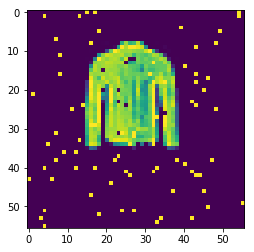

In [4]:
from src.data_loader import norm_to_8bit

sxt = DL.fg_test

noise_ims = skim.util.random_noise(sxt,mode='s&p')
plt.imshow(np.squeeze(noise_ims[50]))

In [27]:
DL.regen_bg_noise(mode='gaussian',var=0.6**2)

adding gaussian noise...


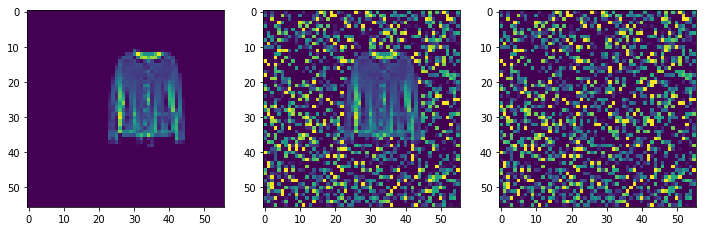

In [28]:
idx = 25
DL.sx_test = DL.fg_test.copy()
DL.add_noise(DL.sx_test,DL.bg_test,bg_only=True)
# DL.add_noise(DL.sx_test,DL.bg_test, bg_only=True)
noise_ims = DL.sx_test
ims = [DL.fg_test[idx],noise_ims[idx],DL.bg_test[idx]]
fig,axs = plt.subplots(1,len(ims),figsize=(len(ims)*4,4))

for im,ax in zip(ims,axs):
    ax.imshow(np.squeeze(im),vmin=0,vmax=1)
#     plt.colorbar()

In [ ]:
modes = ['gaussian','localvar','poisson','salt','pepper','s&p','speckle']
kws = [{'var':0.1},{},{},{},{},{},{'var':0.1}]

orig_im = DL.fg_test[50]
noise_ims = [skim.util.random_noise(orig_im,mode=m,**kwargs) for m,kwargs in zip(modes,kws)]
ims = [orig_im]
ims.extend(noise_ims)

fig,axs = plt.subplots(1,len(ims),figsize=(len(ims)*4,4))

for ax,im in zip(axs,ims):
    ax.imshow(np.squeeze(im))

In [ ]:
plt.imshow(np.squeeze(noise_im))

In [ ]:
cls_masks = [DL.y_test==i for i in np.arange(10)]

In [ ]:
def plot_fg(DL,index=None,cmap='gray',clean=True):
    X = DL.x_test
    sX = DL.fg_test
    
    if index is None:
        idxs = np.random.randint(0,len(X)/10,size=10)
    
    
    im_scale = 3  
    n_rows=2
    n_cols=10
    figure,axs = plt.subplots(n_rows,n_cols,figsize=(n_cols*im_scale,n_rows*im_scale))
    rand_class = 9
    for ax_col,idx,m in zip(np.swapaxes(axs,0,1),idxs,reversed(cls_masks)):
        ax_col[0].imshow(X[m][idx].squeeze(),cmap=cmap)
#         ax_row[1].imshow(sX[m][idx].squeeze(),cmap=cmap)
        ax_col[1].imshow(sX[cls_masks[rand_class]][idx].squeeze(),cmap=cmap)
    
    if clean:
        for ax in np.ravel(axs):
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
#             axs[1].get_xaxis().set_visible(False)
#             axs[1].get_yaxis().set_visible(False)
        plt.tight_layout()
    
    return (idxs)

In [ ]:
plot_fg(DL)

In [ ]:
pt,idx = plot_ovt(DL,cmap='gray')

In [ ]:
neural_data = brainscore.get_assembly(name="dicarlo.Majaj2015")
neural_data.load()
stimulus_set = neural_data.attrs['stimulus_set']

In [ ]:
def process_dicarlo(assembly,avg_repetition=True,variation=3,tasks=['ty','tz','rxy']):
    stimulus_set = assembly.attrs['stimulus_set']
    stimulus_set['dy_deg'] = stimulus_set.tz*stimulus_set.degrees
    stimulus_set['dx_deg'] = stimulus_set.ty*stimulus_set.degrees
    stimulus_set['dy_px'] = stimulus_set.dy_deg*32
    stimulus_set['dx_px'] = stimulus_set.dx_deg*32
    
    assembly.attrs['stimulus_set'] = stimulus_set
    
    data = assembly.sel(variation=variation)
    groups = ['category_name', 'object_name', 'image_id']+tasks
    if not avg_repetition:
        groups.append('repetition')
        
    data = data.multi_groupby(groups)     # (2)
    data = data.mean(dim='presentation')
    data = data.squeeze('time_bin')    #   (3)
    data.attrs['stimulus_set'] = stimulus_set.query('variation == {}'.format(variation))
    data = data.T
    
    return data

In [ ]:
hi_data = process_dicarlo(neural_data,variation=6)

In [ ]:
def SUCorrelation(da,neuroid_coord,correlation_vars,exclude_zeros=True):
    if exclude_zeros:
        nz_neuroids = da.groupby(neuroid_coord).sum('presentation').values!=0
        da = da[:,nz_neuroids]
    
    correlations = np.empty((len(da[neuroid_coord]),len(correlation_vars)))
    for i,nid in tqdm(enumerate(da[neuroid_coord].values),total=len(da[neuroid_coord])):
        for j,prop in enumerate(correlation_vars):
            n_act = da.sel(**{neuroid_coord:nid}).squeeze()
            r,p = pearsonr(n_act,prop)
            correlations[i,j] = np.abs(r)

    neuroid_dim = da[neuroid_coord].dims
    c = {coord: (dims, values) for coord, dims, values in walk_coords(da) if dims == neuroid_dim}
    c['task']=('task',[v.name for v in correlation_vars])
#     print(neuroid_dim)
    result = Score(correlations,
                       coords=c,
                       dims=('neuroid','task'))
    return result

def result_to_df(SUC,corr_var_labels):
    df = SUC.neuroid.to_dataframe().reset_index()
    for label in corr_var_labels:
        df[label]=SUC.sel(task=label).values
    
    return df

In [ ]:
corr_vars_both = [pd.Series(lg_both[v].values,name=v) for v in ['tx','ty']]
corr_both = SUCorrelation(lg_both,neuroid_coord='neuroid_id',correlation_vars=corr_vars_both)
both_df = result_to_df(corr_both,['tx','ty'])
both_df['norm_ty'] = both_df.ty

In [ ]:
corr_vars_xent = [pd.Series(lg_xent[v].values,name=v) for v in ['tx','ty']]
corr_xent = SUCorrelation(lg_xent,neuroid_coord='neuroid_id',correlation_vars=corr_vars_xent)
xent_df = result_to_df(corr_xent,['tx','ty'])
xent_df['norm_ty'] = xent_df.ty

In [ ]:
dicarlo_corr_vars = [
    pd.Series(hi_data['ty'],name='tx'),
    pd.Series(hi_data['tz'],name='ty'),
    pd.Series(hi_data['rxy'],name='rxy'),

]

# corr_dicarlo_med = SUCorrelation(med_data,neuroid_coord='neuroid_id',correlation_vars=dicarlo_med_corr_vars,exclude_zeros=True)
# dicarlo_med_df = result_to_df(corr_dicarlo_med,['tx','ty','rxy'])
# dicarlo_med_df['variation']=3

corr_dicarlo_hi = SUCorrelation(hi_data,neuroid_coord='neuroid_id',correlation_vars=dicarlo_corr_vars,exclude_zeros=True)
dicarlo_df = result_to_df(corr_dicarlo_hi, ['tx','ty','rxy'])
layer_map = {
    'V4':3,
    'IT':4
}

for reg,layer in zip(['V4','IT'],[3,4]):
    dicarlo_df['layer'] = [layer_map[r] for r in dicarlo_df.region]

In [ ]:
def plot_bars(y,df,by='region',order=None):
    if order is not None:
        subsets = order
    else:
        subsets = df[by].drop_duplicates().values
        
    plot_scale = 5
    fig,axs = plt.subplots(1,len(subsets),figsize=(plot_scale*len(subsets),plot_scale),sharex=True,sharey=True,
                           subplot_kw={
#                                'xlim':(0.0,0.8),
#                                'ylim':(0.0,0.8)
                           })
    
    for ax,sub in zip(axs,subsets):
        subsets = df[by].drop_duplicates().values
        sub_df = df.query('{} == "{}"'.format(by,sub))
        sns.barplot(x=by,y=y,ax=ax)

def plot_kde(x,y,df,by='region',order=None):
    if order is not None:
        subsets = order
    else:
        subsets = df[by].drop_duplicates().values
        
    plot_scale = 5
    fig,axs = plt.subplots(1,len(subsets),figsize=(plot_scale*len(subsets),plot_scale),sharex=True,sharey=True,
                           subplot_kw={
                               'xlim':(0.0,0.8),
                               'ylim':(0.0,0.8)
                           })
    
    for ax,sub in zip(axs,subsets):
        sub_df = df.query('{} == "{}"'.format(by,sub))
        sns.kdeplot(sub_df[x],sub_df[y],ax=ax)
        ax.set_title("{}: {}".format(by,sub))
# plot_bars(y='tx',df=both_df,by='layer',order=np.arange(5))

In [ ]:
fig,axs = plt.subplots(2,1,figsize=(5,10),sharex=True)

mod_order=np.arange(5)

for ax,df,order in zip(axs,[xent_df,both_df,],[mod_order,mod_order]): 
    sns.barplot(x='layer',y='tx',order=order,data=df,ax=ax)

In [ ]:
sns.barplot(x='layer',y='tx',data=xent_df)

In [ ]:
sns.violinplot(x='region',y='ty',data=dicarlo_df,order=['V4','IT'])

In [ ]:
plot_kde('tx','ty',dicarlo_df,by='region',order=['V4','IT'])

In [ ]:
class MURegressor(object):
    def __init__(self,da,train_frac=0.8,n_splits=5,n_units=None,estimator=Ridge):
        if n_units is not None:
            self.neuroid_idxs = [np.array([random.randrange(len(da.neuroid_id)) for _ in range(n_units)]) for _ in range(n_splits)]
        
        self.original_data = da
        self.train_frac = train_frac
        self.n_splits = n_splits
        
        splits = [split_assembly(self.original_data[:,n_idxs]) for n_idxs in tqdm(self.neuroid_idxs,total=n_splits,desc='CV-splitting')]
        self.train = [tr for tr,te in splits]
        self.test = [te for tr,te in splits]
        
        
        self.estimators = [estimator() for _ in range(n_splits)]
        
    def fit(self,y_coord):
        # Get Training data
        for mod,train in tqdm(zip(self.estimators,self.train),total=len(self.train),desc='fitting'):
#             print(train)
            mod.fit(X=train.values,y=train[y_coord])
    
        return self
    
    def predict(self,X=None):
        if X is not None:
            return [e.predict(X) for e in self.estimators]
        else:
            return [e.predict(te.values) for e,te in zip(self.estimators,self.test)]
        
    def score(self,y_coord):
        return [e.score(te.values,te[y_coord].values) for e,te in zip(self.estimators,self.test)]
    
def stratified_regressors(data, filt='region',n_units=126,y_coords=['ty','tz'],task_names=None,estimator=Ridge):
    subsets = np.unique(data[filt].values)
    if task_names is None:
        task_names = y_coords
    dfs = []
    for y,task in zip(y_coords,task_names):
        print('regressing {}...'.format(y))
        regressors = {k:MURegressor(data.sel(**{filt:k}),n_units=n_units,estimator=Ridge).fit(y_coord=y) for k in subsets}
        df = pd.DataFrame.from_records({k:v.score(y_coord=y) for k,v in regressors.items()})
        df = df.melt(var_name='region',value_name='performance')
        df['task']=task
        dfs.append(df)
    
    return pd.concat(dfs)

In [ ]:
properties = ['tx','ty']
both_df = stratified_regressors(lg_both,filt='layer',y_coords=properties,n_units=50)

In [ ]:
sns.barplot(x='task',y='performance',hue='region',data=both_df)

In [ ]:
xent_df = stratified_regressors(lg_xent,filt='layer',y_coords=properties,n_units=50)

In [ ]:
sns.barplot(x='task',y='performance',hue='region',data=xent_df)

In [ ]:
plot_kde(x='tx',y='ty',df=both_df,by='layer',order=np.arange(5))

In [ ]:
plot_kde(x='tx',y='ty',df=xent_df,by='layer',order=np.arange(5))